
# exp_serie_de_tiempo_group04.ipynb
**GA Group 04 — Día/Marca. Predicción diaria por marca (serie univariada por marca).**

Comparamos **tres familias**:
1. **Serie de tiempo de una sola acción (univariada):** SARIMA  
2. **Machine Learning:** XGBoost con lags/medias móviles/calendario  
3. **Deep Learning:** LSTM con ventanas deslizantes

Se guardan métricas y predicciones en `./notebooks/`.


## 1) Setup de entorno (si corres en Colab, descomenta)

In [17]:

# !pip -q install statsmodels xgboost pandas==2.2.2 numpy matplotlib scikit-learn pmdarima
# !pip -q install tensorflow
import warnings; warnings.filterwarnings("ignore")


## 2) Imports

In [19]:

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense

plt.rcParams["figure.figsize"] = (12,4)



## 3) Utilidades (carga, features, evaluación)

In [20]:

def load_single_brand_series(parquet_path: str,
                             date_col: str = "transaction_date",
                             brand_col: str = "product_brand",
                             metric_col: str = "events",
                             brand_value: str = "(not set)",
                             freq: str = "D") -> pd.Series:
    df = pd.read_parquet(parquet_path)
    # Parseo de fecha
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        try:
            ser = df[date_col].astype(str).str.zfill(8)
            dt = pd.to_datetime(ser, format="%Y%m%d", errors="coerce")
        except Exception:
            dt = pd.to_datetime(df[date_col], errors="coerce")
        df[date_col] = dt
    else:
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)

    if brand_col in df.columns:
        sub = df[df[brand_col] == brand_value].copy()
    else:
        raise ValueError(f"No se encontró columna de marca '{brand_col}'")
    y = pd.to_numeric(sub[metric_col], errors="coerce")
    daily = y.resample(freq).sum(min_count=1).fillna(0)
    daily.name = metric_col
    return daily

def make_features(series: pd.Series, lags=(1,2,3,5,7,14,21,28), mas=(7,14,28)) -> pd.DataFrame:
    df = pd.DataFrame({"target": series})
    for L in lags:
        df[f"lag_{L}"] = series.shift(L)
    for w in mas:
        df[f"ma_{w}"] = series.shift(1).rolling(w).mean()
    idx = df.index
    df["dow"] = idx.dayofweek
    df["dom"] = idx.day
    df["week"] = idx.isocalendar().week.astype(int)
    df["month"] = idx.month
    df["year"]  = idx.year
    df["is_weekend"] = df["dow"].isin([5,6]).astype(int)
    return df

def evaluate(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mae = float(mean_absolute_error(y_true, y_pred))
    rmse = float(mean_squared_error(y_true, y_pred, squared=False))
    mape = float(np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100.0)
    return {"MAE": mae, "RMSE": rmse, "MAPE%": mape}


## 4) Cargar datos y crear la **serie de una sola acción** (univariada)

transaction_date
2016-08-01 00:00:00+00:00    208.0
2016-08-02 00:00:00+00:00    124.0
2016-08-03 00:00:00+00:00      0.0
2016-08-04 00:00:00+00:00     78.0
2016-08-05 00:00:00+00:00    376.0
Freq: D, Name: events, dtype: float64

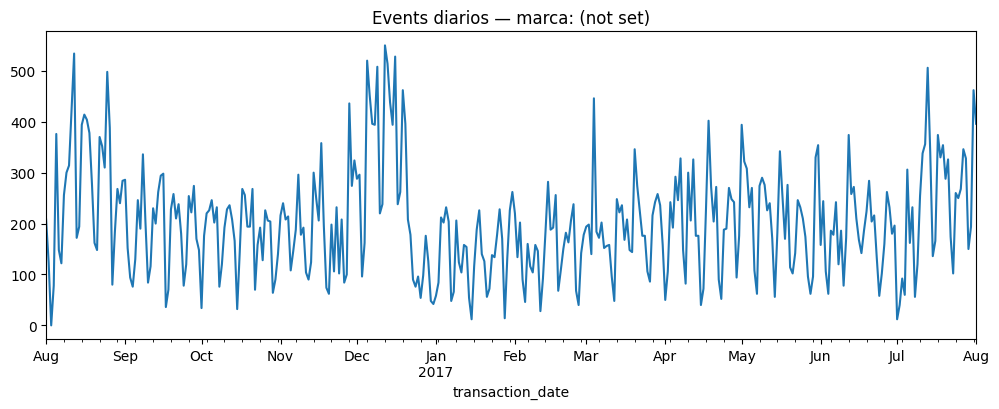

In [21]:
ROOT = Path('..').resolve()
PARQUET_PATH = ROOT / 'data' / 'raw' / 'brand_daily_group04.parquet'
#PARQUET_PATH = "brand_daily_group04.parquet"  # Subir este archivo al runtime
BRAND_VALUE = "(not set)"

series = load_single_brand_series(PARQUET_PATH,
                                  date_col="transaction_date",
                                  brand_col="product_brand",
                                  metric_col="events",
                                  brand_value=BRAND_VALUE,
                                  freq="D")

display(series.head())
series.plot(title=f"Events diarios — marca: {BRAND_VALUE}"); plt.show()

TEST_DAYS = 30
train_y = series.iloc[:-TEST_DAYS]
test_y  = series.iloc[-TEST_DAYS:]


## 5) Modelo 1 — **SARIMA** (single-action, univariado)

⚠️ pmdarima no disponible, usando orden SARIMA manual

Probando m=7...
  Usando orden manual: order=(2, 1, 2), seasonal=(1, 1, 1, 7)
  Métricas: MAE=162.22, RMSE=184.86

Probando m=14...
  Usando orden manual: order=(2, 1, 2), seasonal=(1, 1, 1, 14)
  Métricas: MAE=162.22, RMSE=184.86

Probando m=14...
  Usando orden manual: order=(2, 1, 2), seasonal=(1, 1, 1, 14)
  Métricas: MAE=164.75, RMSE=187.12

Mejor SARIMA manual con m=7
order: (2, 1, 2) seasonal_order: (1, 1, 1, 7)
SARIMA metrics: {'MAE': 162.22251433626664, 'RMSE': 184.86046460725947, 'MAPE%': 61.44721052255376}
  Métricas: MAE=164.75, RMSE=187.12

Mejor SARIMA manual con m=7
order: (2, 1, 2) seasonal_order: (1, 1, 1, 7)
SARIMA metrics: {'MAE': 162.22251433626664, 'RMSE': 184.86046460725947, 'MAPE%': 61.44721052255376}


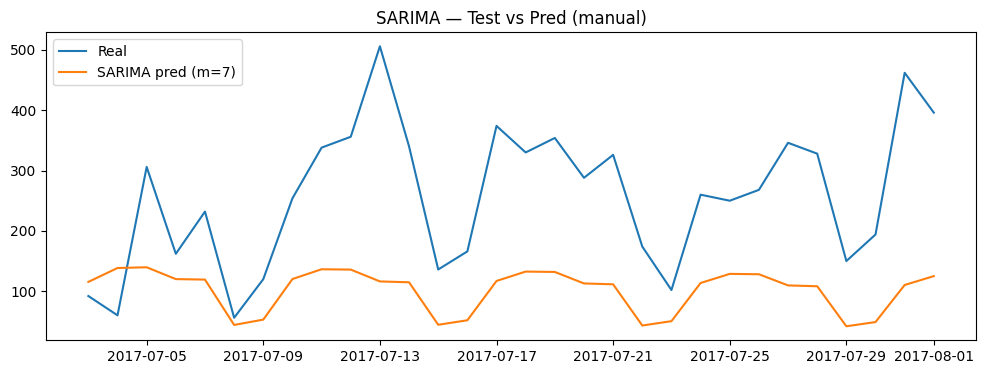

In [28]:
# --- instalar pmdarima si no lo tienes ---
# %pip install -q pmdarima

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Intentar importar pmdarima
try:
    import pmdarima as pm
    HAS_PMDARIMA = True
    print("✓ pmdarima disponible, usando auto_arima")
except ImportError:
    HAS_PMDARIMA = False
    print("⚠️ pmdarima no disponible, usando orden SARIMA manual")

# ---------- utilidades ----------
def evaluate(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mae  = float(mean_absolute_error(y_true, y_pred))
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))  # sin squared=False
    mape = float(np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100.0)
    return {"MAE": mae, "RMSE": rmse, "MAPE%": mape}

def fit_forecast_sarima(train_y, test_y, seasonal_m=7, use_log=True, 
                        manual_order=(2,1,2), manual_seasonal=(1,1,1,7)):
    """Ajusta auto_arima sobre train_y y hace forecast sobre la ventana de test."""
    # Transformación (opcional) para estabilizar varianza
    if use_log:
        train_trans = np.log1p(np.asarray(train_y, dtype=float))
    else:
        train_trans = np.asarray(train_y, dtype=float)

    # Auto ARIMA (solo con train para evitar fuga)
    if HAS_PMDARIMA:
        try:
            auto_model = pm.auto_arima(
                train_trans,
                seasonal=True,
                m=seasonal_m,
                stepwise=True,
                trace=False,
                error_action="ignore",
                suppress_warnings=True,
                max_p=5, max_q=5, max_P=3, max_Q=3,
                max_order=None,  # respeta límites individuales
                information_criterion="aic"
            )
            order = auto_model.order
            seasonal_order = auto_model.seasonal_order
            print(f"  ✓ auto_arima (m={seasonal_m}): order={order}, seasonal={seasonal_order}")
        except Exception as e:
            print(f"  ⚠️ auto_arima falló: {e}, usando orden manual")
            order = manual_order
            seasonal_order = (manual_seasonal[0], manual_seasonal[1], 
                            manual_seasonal[2], seasonal_m)
    else:
        order = manual_order
        seasonal_order = (manual_seasonal[0], manual_seasonal[1], 
                        manual_seasonal[2], seasonal_m)
        print(f"  Usando orden manual: order={order}, seasonal={seasonal_order}")

    # Re-ajustar con SARIMAX "real" sobre train_y (misma transformación)
    if use_log:
        sarima = SARIMAX(np.log1p(train_y),
                         order=order, seasonal_order=seasonal_order,
                         enforce_stationarity=False, enforce_invertibility=False)
        fit = sarima.fit(disp=False)
        fc_scaled = fit.forecast(steps=len(test_y))
        forecast = np.expm1(fc_scaled)  # revertir log1p
    else:
        sarima = SARIMAX(train_y,
                         order=order, seasonal_order=seasonal_order,
                         enforce_stationarity=False, enforce_invertibility=False)
        fit = sarima.fit(disp=False)
        forecast = fit.forecast(steps=len(test_y))

    return {
        "order": order,
        "seasonal_order": seasonal_order,
        "forecast": forecast,
        "fit": fit
    }

# ---------- aseguramos frecuencia diaria explícita (por si acaso) ----------
train_y = train_y.asfreq("D")
test_y  = test_y.asfreq("D")

# ---------- probamos m=7 y m=14, elegimos el mejor ----------
candidates = []
for m in (7, 14):
    print(f"\nProbando m={m}...")
    res = fit_forecast_sarima(train_y, test_y, seasonal_m=m, use_log=True)
    mets = evaluate(test_y, res["forecast"])
    candidates.append((m, res, mets))
    print(f"  Métricas: MAE={mets['MAE']:.2f}, RMSE={mets['RMSE']:.2f}")

# elegir por RMSE
best_m, best_res, best_metrics = sorted(candidates, key=lambda x: x[2]["RMSE"])[0]

print(f"\n{'='*60}")
print(f"Mejor SARIMA {'auto_arima' if HAS_PMDARIMA else 'manual'} con m={best_m}")
print("order:", best_res["order"], "seasonal_order:", best_res["seasonal_order"])
print("SARIMA metrics:", best_metrics)
print(f"{'='*60}")

# ---------- gráfico Real vs Pred ----------
plt.plot(test_y.index, test_y.values, label="Real")
plt.plot(test_y.index, best_res["forecast"], label=f"SARIMA pred (m={best_m})")
plt.title(f"SARIMA — Test vs Pred ({'auto_arima' if HAS_PMDARIMA else 'manual'})")
plt.legend()
plt.show()

# Guardar métricas para comparación final
sarima_metrics = best_metrics

## 6) Modelo 2 — **XGBoost** (ML con features de la serie)

XGBoost metrics: {'MAE': 67.74270350138346, 'RMSE': 94.38793494434684, 'MAPE%': 36.80496989411619}


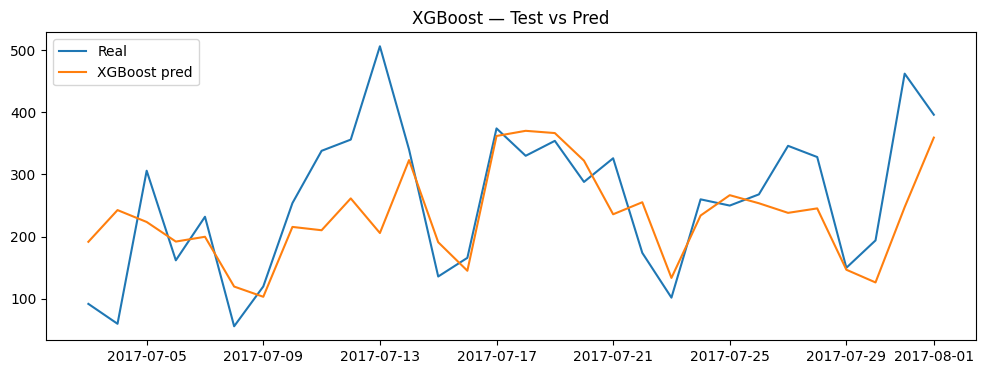

In [29]:

fe = make_features(series).dropna()
train_fe = fe.iloc[:-TEST_DAYS]
test_fe  = fe.iloc[-TEST_DAYS:]

X_train = train_fe.drop(columns=["target"])
y_train = train_fe["target"]
X_test  = test_fe.drop(columns=["target"])
y_test  = test_fe["target"]

xgb = XGBRegressor(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42
)
xgb.fit(X_train, y_train)
xgb_pred = pd.Series(xgb.predict(X_test), index=y_test.index)

xgb_metrics = evaluate(y_test, xgb_pred)
print("XGBoost metrics:", xgb_metrics)

plt.plot(y_test.index, y_test.values, label="Real")
plt.plot(y_test.index, xgb_pred.values, label="XGBoost pred")
plt.title("XGBoost — Test vs Pred")
plt.legend(); plt.show()


## 7) Modelo 3 — **LSTM** (DL con secuencias)

LSTM metrics: {'MAE': 97.42444610595703, 'RMSE': 122.71245129621117, 'MAPE%': 45.92972183227539}


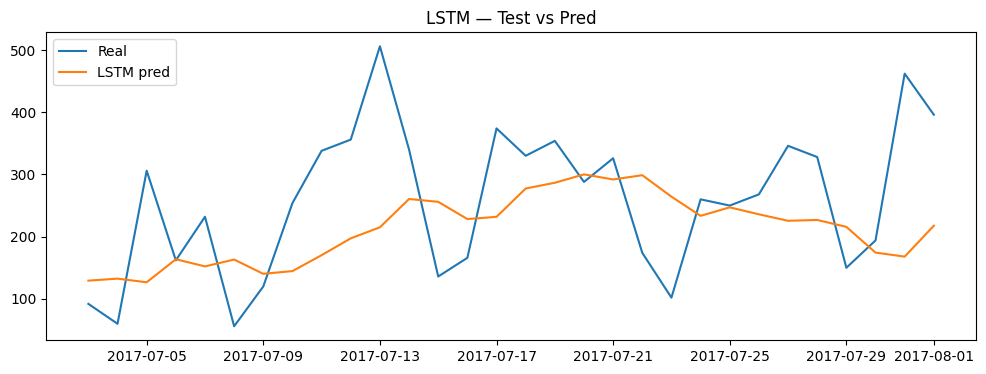

In [30]:

from sklearn.preprocessing import MinMaxScaler

def build_sequences(y: pd.Series, lookback: int = 30):
    vals = y.values.astype("float32").reshape(-1, 1)
    scaler = MinMaxScaler()
    vals_scaled = scaler.fit_transform(vals)
    X, Y = [], []
    for i in range(lookback, len(vals_scaled)):
        X.append(vals_scaled[i-lookback:i, 0])
        Y.append(vals_scaled[i, 0])
    X = np.array(X)[:, :, None]  # (samples, lookback, 1)
    Y = np.array(Y)
    return X, Y, scaler

LOOKBACK = 30
X_all, Y_all, scaler_y = build_sequences(series, lookback=LOOKBACK)
idx_all = series.index[LOOKBACK:]
split = len(idx_all) - TEST_DAYS
X_train_lstm, X_test_lstm = X_all[:split], X_all[split:]
Y_train_lstm, Y_test_lstm = Y_all[:split], Y_all[split:]
idx_test_lstm = idx_all[split:]

model = Sequential([
    LSTM(64, activation="tanh", input_shape=(LOOKBACK, 1)),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
history = model.fit(X_train_lstm, Y_train_lstm, epochs=30, batch_size=16,
                    validation_split=0.1, verbose=0)

Y_pred_scaled = model.predict(X_test_lstm, verbose=0)
Y_pred = scaler_y.inverse_transform(Y_pred_scaled).ravel()
Y_true = scaler_y.inverse_transform(Y_test_lstm.reshape(-1,1)).ravel()

lstm_pred = pd.Series(Y_pred, index=idx_test_lstm)
lstm_true = pd.Series(Y_true, index=idx_test_lstm)

lstm_metrics = evaluate(lstm_true, lstm_pred)
print("LSTM metrics:", lstm_metrics)

plt.plot(idx_test_lstm, lstm_true.values, label="Real")
plt.plot(idx_test_lstm, lstm_pred.values, label="LSTM pred")
plt.title("LSTM — Test vs Pred")
plt.legend(); plt.show()


## 8) Comparación 

In [32]:

results = pd.DataFrame([
    {"modelo": "SARIMA", **sarima_metrics},
    {"modelo": "XGBoost", **xgb_metrics},
    {"modelo": "LSTM", **lstm_metrics},
]).set_index("modelo").sort_values("RMSE")

display(results)






,MAE,RMSE,MAPE%
modelo,,,
XGBoost,67.742704,94.387935,36.804970
LSTM,97.424446,122.712451,45.929722
SARIMA,162.222514,184.860465,61.447211



### Notas
XGBoost arrasa en todas las métricas (menores errores = mejor). Si el objetivo es predecir "performance diaria por marca" con precisión práctica (ej. para negocio), XGBoost es tu MVP.


### Probando trainning.py e prediction.py de XGBoost ganador